In [13]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import math
import tensorflow
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import mean_squared_error
import seaborn as sns
import pickle

In [15]:
data = pd.read_csv('Tomato.csv')

In [17]:
#Drop na's.
data.dropna(axis=0, inplace=True) #remove all rows with na's.
data.reset_index(drop=True)

,date,centre_name,commodity_name,price
0,2001-01-09,DELHI,Tomato,34
1,2001-01-09,MUMBAI,Tomato,26
2,2001-01-10,DELHI,Tomato,13
3,2001-01-13,DELHI,Tomato,15
4,2001-01-13,MUMBAI,Tomato,17
...,...,...,...,...
1819,2015-12-11,MUMBAI,Tomato,16
1820,2015-12-11,KOLKATA,Tomato,18
1821,2015-12-14,DELHI,Tomato,26
1822,2015-12-14,MUMBAI,Tomato,24


In [19]:
#calculate average price for each centre for each day 
data_gp = data.sort_values('date').groupby(['centre_name', 'date'], as_index=False)
data_gp = data_gp.agg({'price':['mean']})
data_gp.columns = ['centre_name', 'date', 'price']
data_gp.head()

,centre_name,date,price
0,DELHI,2001-01-09,34
1,DELHI,2001-01-10,13
2,DELHI,2001-01-13,15
3,DELHI,2001-01-14,30
4,DELHI,2001-01-15,36


In [21]:
#centre_1_train_dataset
centre_1_data = data_gp.loc[(data_gp['centre_name']=="DELHI"),["price"]].values
centre_1_data = centre_1_data.astype("float32")

#centre_2_train_dataset
centre_2_data = data_gp.loc[(data_gp['centre_name']=="KOLKATA"),["price"]].values
centre_2_data = centre_2_data.astype("float32")

#centre_2_train_dataset
centre_3_data = data_gp.loc[(data_gp['centre_name']=="MUMBAI"),["price"]].values
centre_3_data = centre_3_data.astype("float32")

print(centre_1_data.size,centre_2_data.size,centre_3_data.size)

774 446 604


In [23]:
#take last year as test dataset
train_centre_1 = centre_1_data[:-365]
test_centre_1 = centre_1_data[-365:]

train_centre_2 = centre_2_data[:-365]
test_centre_2 = centre_2_data[-365:]

train_centre_3 = centre_3_data[:-365]
test_centre_3 = centre_3_data[-365:]

print("train size: {}, test size: {}".format(len(train_centre_1), len(test_centre_1)))

train size: 409, test size: 365


In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#transform the data using minmax scaler
scaler_2 = MinMaxScaler(feature_range=(0,1))
scaler_3 = MinMaxScaler(feature_range=(0,1))

train_centre_1 = scaler.fit_transform(train_centre_1)
test_centre_1 = scaler.transform(test_centre_1)

train_centre_2 = scaler_2.fit_transform(train_centre_2)
test_centre_2 = scaler_2.transform(test_centre_2)

train_centre_3 = scaler_3.fit_transform(train_centre_3)
test_centre_3 = scaler_3.transform(test_centre_3)

In [27]:
#train:

time_step = 30
datax_centre_1=[]
datay_centre_1=[]

for i in range(len(train_centre_1)-time_step-1):
    datax_centre_1.append(train_centre_1[i:(i+time_step),0])
    datay_centre_1.append(train_centre_1[i+time_step,0])
trainx_centre_1=np.array(datax_centre_1)
trainy_centre_1=np.array(datay_centre_1)

datax_centre_2=[]
datay_centre_2=[]

for i in range(len(train_centre_2)-time_step-1):
    datax_centre_2.append(train_centre_2[i:(i+time_step),0])
    datay_centre_2.append(train_centre_2[i+time_step,0])
trainx_centre_2=np.array(datax_centre_2)
trainy_centre_2=np.array(datay_centre_2)

datax_centre_3=[]
datay_centre_3=[]

for i in range(len(train_centre_3)-time_step-1):
    datax_centre_3.append(train_centre_3[i:(i+time_step),0])
    datay_centre_3.append(train_centre_3[i+time_step,0])
trainx_centre_3=np.array(datax_centre_3)
trainy_centre_3=np.array(datay_centre_3)

In [29]:
#test:

datax_centre_1=[]
datay_centre_1=[]

for i in range(len(test_centre_1)-time_step-1):
    datax_centre_1.append(test_centre_1[i:(i+time_step),0])
    datay_centre_1.append(test_centre_1[i+time_step,0])
testx_centre_1=np.array(datax_centre_1)
testy_centre_1=np.array(datay_centre_1)


datax_centre_2=[]
datay_centre_2=[]

for i in range(len(test_centre_2)-time_step-1):
    datax_centre_2.append(test_centre_2[i:(i+time_step),0])
    datay_centre_2.append(test_centre_2[i+time_step,0])
testx_centre_2=np.array(datax_centre_2)
testy_centre_2=np.array(datay_centre_2)

datax_centre_3=[]
datay_centre_3=[]

for i in range(len(test_centre_3)-time_step-1):
    datax_centre_3.append(test_centre_3[i:(i+time_step),0])
    datay_centre_3.append(test_centre_3[i+time_step,0])
testx_centre_3=np.array(datax_centre_3)
testy_centre_3=np.array(datay_centre_3)

In [31]:
trainx_centre_1=np.reshape(trainx_centre_1, (trainx_centre_1.shape[0],1,trainx_centre_1.shape[1]))
testx_centre_1=np.reshape(testx_centre_1, (testx_centre_1.shape[0],1,testx_centre_1.shape[1]))

trainx_centre_2=np.reshape(trainx_centre_2, (trainx_centre_2.shape[0],1,trainx_centre_2.shape[1]))
testx_centre_2=np.reshape(testx_centre_2, (testx_centre_2.shape[0],1,testx_centre_2.shape[1]))

trainx_centre_3=np.reshape(trainx_centre_3, (trainx_centre_3.shape[0],1,trainx_centre_3.shape[1]))
testx_centre_3=np.reshape(testx_centre_3, (testx_centre_3.shape[0],1,testx_centre_3.shape[1]))


In [33]:
model =Sequential()
model.add(LSTM(20, input_shape=(1, time_step))) #20 LSTM neuron
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history_1 = model.fit(trainx_centre_1, trainy_centre_1, epochs=100, batch_size=32,    validation_split=0.1, shuffle=False)

Epoch 1/100
11/11 [==============================] - 1s 72ms/step - loss: 1.0901 - val_loss: 1.2778
Epoch 2/100
11/11 [==============================] - 0s 6ms/step - loss: 1.0249 - val_loss: 1.1934
Epoch 3/100
11/11 [==============================] - 0s 7ms/step - loss: 0.9757 - val_loss: 1.1262
Epoch 4/100
11/11 [==============================] - 0s 7ms/step - loss: 0.9364 - val_loss: 1.0730
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 0.9045 - val_loss: 1.0308
Epoch 6/100
11/11 [==============================] - 0s 7ms/step - loss: 0.8779 - val_loss: 0.9968
Epoch 7/100
11/11 [==============================] - 0s 9ms/step - loss: 0.8551 - val_loss: 0.9689
Epoch 8/100
11/11 [==============================] - 0s 7ms/step - loss: 0.8350 - val_loss: 0.9457
Epoch 9/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8168 - val_loss: 0.9260
Epoch 10/100
11/11 [==============================] - 0s 7ms/step - loss: 0.8000 - val_loss: 0.9090
Epoch 11

In [35]:
model_2 =Sequential()
model_2.add(LSTM(20, input_shape=(1, time_step))) #20 LSTM neuron
model_2.add(Dense(1))
model_2.compile(loss='mean_squared_error', optimizer='adam')
history_2 = model.fit(trainx_centre_2, trainy_centre_2, epochs=100, batch_size=32,   validation_split=0.1, shuffle=False)

Epoch 1/100
2/2 [==============================] - 0s 27ms/step - loss: 0.1836 - val_loss: 0.2965
Epoch 2/100
2/2 [==============================] - 0s 20ms/step - loss: 0.1623 - val_loss: 0.2513
Epoch 3/100
2/2 [==============================] - 0s 18ms/step - loss: 0.1293 - val_loss: 0.1989
Epoch 4/100
2/2 [==============================] - 0s 18ms/step - loss: 0.0967 - val_loss: 0.1499
Epoch 5/100
2/2 [==============================] - 0s 19ms/step - loss: 0.0724 - val_loss: 0.1104
Epoch 6/100
2/2 [==============================] - 0s 27ms/step - loss: 0.0589 - val_loss: 0.0822
Epoch 7/100
2/2 [==============================] - 0s 22ms/step - loss: 0.0548 - val_loss: 0.0643
Epoch 8/100
2/2 [==============================] - 0s 21ms/step - loss: 0.0561 - val_loss: 0.0541
Epoch 9/100
2/2 [==============================] - 0s 22ms/step - loss: 0.0587 - val_loss: 0.0491
Epoch 10/100
2/2 [==============================] - 0s 19ms/step - loss: 0.0595 - val_loss: 0.0470
Epoch 11/100
2/2 [=

In [36]:
model_3 =Sequential()
model_3.add(LSTM(20, input_shape=(1, time_step))) #20 LSTM neuron
model_3.add(Dense(1))
model_3.compile(loss='mean_squared_error', optimizer='adam')
history_3 = model.fit(trainx_centre_3, trainy_centre_3, epochs=100, batch_size=32,  validation_split=0.1, shuffle=False) 

Epoch 1/100
6/6 [==============================] - 0s 12ms/step - loss: 0.0329 - val_loss: 0.0571
Epoch 2/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0323 - val_loss: 0.0559
Epoch 3/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0318 - val_loss: 0.0551
Epoch 4/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0314 - val_loss: 0.0546
Epoch 5/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0309 - val_loss: 0.0542
Epoch 6/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0304 - val_loss: 0.0538
Epoch 7/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0299 - val_loss: 0.0534
Epoch 8/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0295 - val_loss: 0.0528
Epoch 9/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0291 - val_loss: 0.0523
Epoch 10/100
6/6 [==============================] - 0s 8ms/step - loss: 0.0287 - val_loss: 0.0518
Epoch 11/100
6/6 [==========

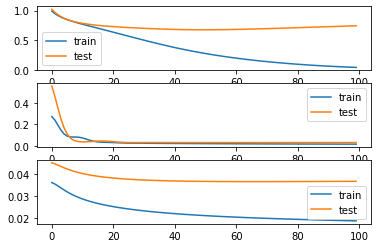

In [18]:
fig = plt.figure()
plt.subplot(3, 1, 1)
plt.plot(history_1.history['loss'], label='train')
plt.plot(history_1.history['val_loss'], label='test')
plt.legend();

plt.subplot(3, 1, 2)
plt.plot(history_2.history['loss'], label='train')
plt.plot(history_2.history['val_loss'], label='test')
plt.legend();

plt.subplot(3, 1, 3)
plt.plot(history_3.history['loss'], label='train')
plt.plot(history_3.history['val_loss'], label='test')
plt.legend();

In [20]:
trainy_centre_1 = trainy_centre_1.reshape(1,-1)
testy_centre_1 = testy_centre_1.reshape(1,-1)

trainy_centre_2 = trainy_centre_2.reshape(1,-1)
testy_centre_2 = testy_centre_2.reshape(1,-1)

trainy_centre_3 = trainy_centre_3.reshape(1,-1)
testy_centre_3 = testy_centre_3.reshape(1,-1)

In [22]:
testPredict_centre_1 = model.predict(testx_centre_1)
testPredict_centre_1 = scaler.inverse_transform(testPredict_centre_1)
testy_centre_1 = scaler.inverse_transform(testy_centre_1)
trainPredict_centre_1 = model.predict(trainx_centre_1)
trainPredict_centre_1 = scaler.inverse_transform(trainx_centre_1)
trainy_centre_1 = scaler.inverse_transform(trainy_centre_1)

testPredict_centre_2 = model.predict(testx_centre_2)
trainPredict_centre_2 = model.predict(trainx_centre_2)
trainPredict_centre_2 = scaler.inverse_transform(trainx_centre_2)
testPredict_centre_2 = scaler.inverse_transform(testPredict_centre_2)
testy_centre_2 = scaler.inverse_transform(testy_centre_2)
trainy_centre_2 = scaler.inverse_transform(trainy_centre_2)

testPredict_centre_3 = model.predict(testx_centre_3)
trainPredict_centre_3 = model.predict(trainx_centre_3)
trainPredict_centre_3 = scaler.inverse_transform(trainx_centre_3)
testPredict_centre_3 = scaler.inverse_transform(testPredict_centre_3)
testy_centre_3 = scaler.inverse_transform(testy_centre_3)
trainy_centre_3 = scaler.inverse_transform(trainy_centre_3)

<Figure size 432x288 with 0 Axes>

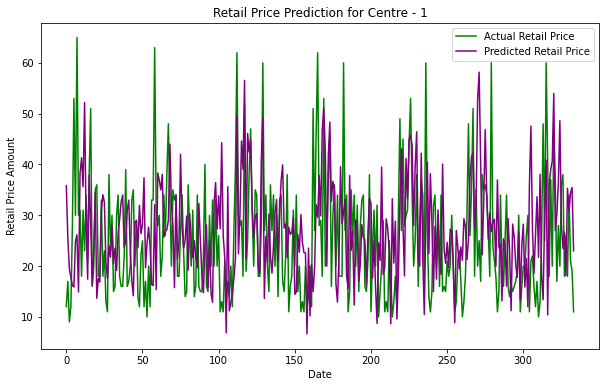

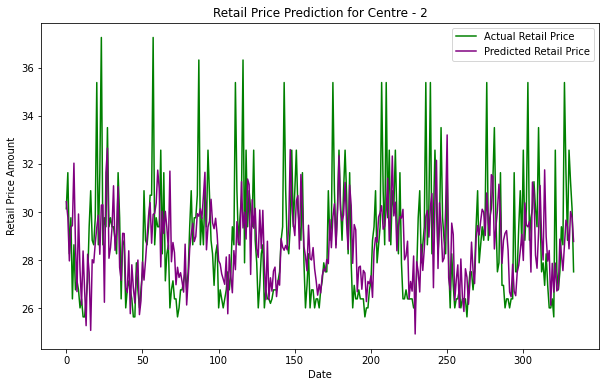

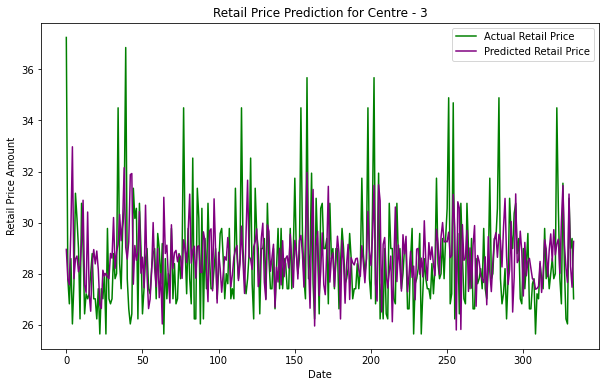

In [24]:
fig = plt.figure()
plt.figure(figsize=(10,6))
plt.plot(testy_centre_1[0], color='green', label='Actual Retail Price')
plt.plot(testPredict_centre_1 , color='purple', label='Predicted Retail Price')
plt.title('Retail Price Prediction for Centre - 1')
plt.xlabel('Date')
plt.ylabel('Retail Price Amount')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(testy_centre_2[0], color='green', label='Actual Retail Price')
plt.plot(testPredict_centre_2 , color='purple', label='Predicted Retail Price')
plt.title('Retail Price Prediction for Centre - 2')
plt.xlabel('Date')
plt.ylabel('Retail Price Amount')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(testy_centre_3[0], color='green', label='Actual Retail Price')
plt.plot(testPredict_centre_3 , color='purple', label='Predicted Retail Price')
plt.title('Retail Price Prediction for Centre - 3')
plt.xlabel('Date')
plt.ylabel('Retail Price Amount')
plt.legend()
plt.show()

In [26]:
# trainscore = math.sqrt(mean_squared_error(trainy_centre_1[0], trainPredict_centre_1[:,0]))
# testscore = math.sqrt(mean_squared_error(testy_centre_1[0], testPredict_centre_1[:,0]))
# print("Train MSE: {}, Test MSE: {}".format(trainscore, testscore))

# trainscore = math.sqrt(mean_squared_error(trainy_centre_1[0], trainPredict_centre_1[:,0]))
# testscore = math.sqrt(mean_squared_error(testy_centre_1[0], testPredict_centre_1[:,0]))
# print("Train MSE for centre 1 model : {}, Test MSE: {}".format(trainscore, testscore))

# trainscore = math.sqrt(mean_squared_error(trainy_centre_2[0], trainPredict_centre_2[:,0]))
# testscore = math.sqrt(mean_squared_error(testy_centre_2[0], testPredict_centre_2[:,0]))
# print("Train MSE for centre 2 model : {}, Test MSE: {}".format(trainscore, testscore))

# trainscore = math.sqrt(mean_squared_error(trainy_centre_3[0], trainPredict_centre_3[:,0]))
# testscore = math.sqrt(mean_squared_error(testy_centre_3[0], testPredict_centre_3[:,0]))
# print("Train MSE for centre 3 model : {}, Test MSE: {}".format(trainscore, testscore))

In [28]:
print(trainy_centre_2[0], trainPredict_centre_2[:,0])

0.032258064 [[27.138273 26.015009 26.015009 ... 28.63596  26.015009 26.951063]
 [26.015009 26.015009 26.015009 ... 26.015009 26.951063 26.015009]
 [26.015009 26.015009 26.389431 ... 26.951063 26.015009 26.389431]
 ...
 [29.384804 34.439495 30.133646 ... 28.63596  30.69528  29.759226]
 [34.439495 30.133646 29.384804 ... 30.69528  29.759226 29.384804]
 [30.133646 29.384804 28.823172 ... 29.759226 29.384804 34.439495]]


# Predicting 90 days of 2015

In [30]:
#use retail price of last 30 days of 2014 to predict next 90 days

#centre-1
testPredict_centre_1 = []

x_data_centre_1 = testx_centre_1[-1] #get transformed retail price values of last 30 days 
x_centre_1 = np.reshape(x_data_centre_1,(1,1,30))
yhat = model.predict(x_centre_1)
testPredict_centre_1 = np.append(testPredict_centre_1,scaler.inverse_transform(yhat))
x_data_centre_1 = np.append(x_data_centre_1,yhat)

for i in range (89):
        x_data_centre_1 = x_data_centre_1[1:]
        x_centre_1 = np.reshape(x_data_centre_1,(1,1,30))
        yhat = model.predict(x_centre_1)
        testPredict_centre_1 = np.append(testPredict_centre_1,scaler.inverse_transform(yhat))
        x_data_centre_1 = np.append(x_data_centre_1,yhat)
        
#centre-2     
testPredict_centre_2 = []

x_data_centre_2 = testx_centre_2[-1] #get transformed retail price values of last 30 days 
x_centre_2 = np.reshape(x_data_centre_2,(1,1,30))
yhat = model.predict(x_centre_2)
testPredict_centre_2 = np.append(testPredict_centre_2,scaler.inverse_transform(yhat))
x_data_centre_2 = np.append(x_data_centre_2,yhat)

for i in range (89):
        x_data_centre_2 = x_data_centre_2[1:]
        x_centre_2 = np.reshape(x_data_centre_2,(1,1,30))
        yhat = model.predict(x_centre_2)
        testPredict_centre_2 = np.append(testPredict_centre_2,scaler.inverse_transform(yhat))
        x_data_centre_2 = np.append(x_data_centre_2,yhat)
        
#centre-3
testPredict_centre_3 = []

x_data_centre_3 = testx_centre_3[-1] #get transformed retail price values of last 30 days 
x_centre_3 = np.reshape(x_data_centre_3,(1,1,30))
yhat = model.predict(x_centre_3)
testPredict_centre_3 = np.append(testPredict_centre_3,scaler.inverse_transform(yhat))
x_data_centre_3 = np.append(x_data_centre_3,yhat)

for i in range (89):
        x_data_centre_3 = x_data_centre_3[1:]
        x_centre_3 = np.reshape(x_data_centre_3,(1,1,30))
        yhat = model.predict(x_centre_3)
        testPredict_centre_3 = np.append(testPredict_centre_3,scaler.inverse_transform(yhat))
        x_data_centre_3 = np.append(x_data_centre_3,yhat)
        


In [32]:
#Create Dataframe with predicted retail prices
centre_1_test_df = pd.DataFrame(columns = ['date','centre_name', 'commodity_name', 'predicted_retail_price'])
centre_1_test_df['date']=pd.date_range(start='1/1/2015' ,end = '31/3/2015', freq='D')
centre_1_test_df['centre_name'] = "DELHI"
centre_1_test_df['commodity_name'] = "Tomato"
centre_1_test_df['predicted_retail_price'] = testPredict_centre_1

#Create Dataframe with predicted retail prices
centre_2_test_df = pd.DataFrame(columns = ['date','centre_name', 'commodity_name', 'predicted_retail_price'])
centre_2_test_df['date']=pd.date_range(start='1/1/2015' ,end = '31/3/2015', freq='D')
centre_2_test_df['centre_name'] = "KOLKATA"
centre_2_test_df['commodity_name'] = "Tomato"
centre_2_test_df['predicted_retail_price'] = testPredict_centre_2

#Create Dataframe with predicted retail prices
centre_3_test_df = pd.DataFrame(columns = ['date','centre_name', 'commodity_name', 'predicted_retail_price'])
centre_3_test_df['date']=pd.date_range(start='1/1/2015' ,end = '31/3/2015', freq='D')
centre_3_test_df['centre_name'] = "MUMBAI"
centre_3_test_df['commodity_name'] = "Tomato"
centre_3_test_df['predicted_retail_price'] = testPredict_centre_3

test_df = pd.concat([centre_1_test_df , centre_2_test_df, centre_3_test_df],ignore_index=True)
test_df

,date,centre_name,commodity_name,predicted_retail_price
0,2015-01-01,DELHI,Tomato,22.989538
1,2015-01-02,DELHI,Tomato,33.786621
2,2015-01-03,DELHI,Tomato,21.863499
3,2015-01-04,DELHI,Tomato,20.866306
4,2015-01-05,DELHI,Tomato,32.283241
...,...,...,...,...
265,2015-03-27,MUMBAI,Tomato,28.774023
266,2015-03-28,MUMBAI,Tomato,28.722433
267,2015-03-29,MUMBAI,Tomato,28.736872
268,2015-03-30,MUMBAI,Tomato,28.787891


In [34]:
test_df.to_csv('lstm_price_prediction_tomato.csv',index=False)